In [1]:
import numpy as np
import matplotlib.pyplot as plt

# print options
np.set_printoptions(precision=3)

from chroma import *


In [ ]:
# create a synthetic function

def normalize_sequence(x):
    length = np.linalg.norm(x, axis=0)
    return x / length

def create_sequences():
    L = 20
    w = np.linspace(0, np.pi/2, L)
    ref = np.stack((np.sin(w), np.cos(w))) + 0.10 * np.random.random((2,L))
    ref = normalize_sequence(ref)

    L = 30
    w = np.linspace(0, np.pi/2, L)
    
    # this will make a non-linear matching path
    #     w = np.pi/2 * np.sin(w)
    live = np.stack((np.sin(w), np.cos(w)))  + 0.10 * np.random.random((2,L))
    live = normalize_sequence(live)
    return ref, live


In [2]:
def dtw(seq_a, seq_b):
    # matrix dimensions
    M = seq_a.shape[1]
    N = seq_b.shape[1]

    # create the cost matrix:
    cost = 1 - np.dot(seq_a.T, seq_b)
    
    # accumulated cost matrix:
    acc_cost = np.zeros((M,N))

    # backtracking matrix:
    back = np.empty((M,N), dtype=np.int)

    # initalize accumulated cost matrix:
    acc_cost[0,0] = cost[0,0]
    back[0,0] = 2
    
    for i in range(1,M):
        acc_cost[i,0] = cost[i,0] + acc_cost[i-1, 0]
        back[i,0] = 1
    for j in range(1,N):
        acc_cost[0,j] = cost[0,j] + acc_cost[0, j-1]
        back[0,j] = 0
    
    STEPS = [(0, -1), (-1, 0), (-1, -1)]
    # DTW algorithm
    for i in range(1,M):
        for j in range(1,N):
            # check 3 steps ending up at i,j:
            options = (acc_cost[i  ,j-1] + cost[i,j],
                       acc_cost[i-1,j]   + cost[i,j],
                       acc_cost[i-1,j-1] + 2*cost[i,j])
            best_step = np.argmin(options)
            acc_cost[i,j] = options[best_step]
            back[i,j] = best_step
    
    # backtrack for path compuation:
    i = M - 1
    j = N - 1
    path = [(i,j)]
    while i > 0 or j > 0:
        step = STEPS[ back[i,j] ]
        i += step[0]
        j += step[1]
        path.append( (i,j) )
    path.reverse()
    path = np.array(path)
    return cost, acc_cost, path

In [ ]:
ref_seq, live_seq = create_sequences()
dtw_cost, dtw_acc_cost, dtw_path = dtw(live_seq, ref_seq)

In [ ]:
plt.imshow(dtw_acc_cost)
plt.plot(dtw_path[:,1], dtw_path[:,0], 'r')
plt.show()

In [ ]:
dtw_acc_cost[0:5, 0:5]

In [ ]:
print dtw_path

In [3]:
# Implementation of Online Time Warping Based on Dixon 2005
# This follows the algorithm in the paper very closely, but also fixes some bugs
class OnlineTimeWarping(object):
    def __init__(self, ref, params):
        super(OnlineTimeWarping, self).__init__()

        self.c = params['c']
        self.max_run_count = params['max_run_count']

        F = ref.shape[0]     # number of features
        N = ref.shape[1]     # length of ref sequence
        M = 2 * ref.shape[1] # length of live sequence (2x for now)

        # refernce sequence
        self.ref = ref 
        
        # live sequence:
        self.live = -1 * np.ones((F, M))
        
        # cost matrix
        self.cost = -1 * np.ones((M,N))
        
        # acc cost matrix. Initialize with large values to handle
        # non-computed edges
        self.acc_cost = 10**10 * np.ones((M,N))
        
        self.path = []
        
        # algorithm state vars
        self.t = 0 # index into live
        self.j = 0 # index into ref
        self.previous = None
        self.run_count = 1
        
    # this function sets the entire "live" data at once, which is not how
    # it will run in real-time, but more closely matches the algorithm in the
    # paper.
    def set_live(self, live):
        self.t = 0
        self.j = 0
        self.previous = None
        self.run_count = 0
        self.path = []
        
        self.fill_input(live)
        self.eval_path_cost(self.t, self.j)
        
        while True:
            print '\n\ncur index', self.t, self.j
            
            # Unlike paper, only call get_inc once at the start of each loop.
            direction = self.get_inc()
            print direction
            
            # Process a Row ('Row' or 'Both')
            if direction != 'Column':
                self.t += 1
                # check end conditions
                if self.t >= live.shape[1]:
                    print 'Done. Ran out of live sequence'
                    break
                if self.t >= self.live.shape[1]:
                    print 'Done. Ran out of room in pre-allocated live-sequence'
                    break

                self.fill_input(live)
                k1 = max(0, self.j - self.c + 1)
                k2 = self.j + 1
                print 'row[{} : {},{}]'.format(self.t, k1, k2)
                for k in range(k1, k2):
                    self.eval_path_cost(self.t, k)
                
            # Process a Column ('Column' or 'Both')
            if direction != 'Row':
                self.j += 1
                # check end conditions
                if self.j >= self.ref.shape[1]:
                    print 'Done. Ran out of ref-sequence'
                    break
                
                k1 = max(0, self.t - self.c + 1)
                k2 = self.t + 1
                print 'col[{},{} : {}]'.format(k1, k2, self.j)
                for k in range(k1, k2):
                    self.eval_path_cost(k, self.j)
                
            # update run_count - the number of time we see
            # consecutive rows or consecutive coluns.
            if direction == self.previous:
                self.run_count += 1
            else:
                self.run_count = 1
            print 'run-count', self.run_count
            if direction != 'Both':
                self.previous = direction

        # turn path into np.array at end.
        self.path = np.array(self.path)
    
    
    # this is INPUT(t). It fills in one additional step from the live input
    # into the current pointer, self.t
    def fill_input(self, live):
        self.live[:,self.t] = live[:,self.t] 
    
    # This does two things: calculates if next update show be 
    # row, column, or both. And finds the current optimal point and adds it to the
    # path.
    def get_inc(self):
        print '  Get Inc at ({},{})'.format(self.t, self.j)

        # moved this calculation to happen all the time, so that we can
        # have a path right from the start:
        x,y = self.best_point()
        print '    best_point: ({},{})'.format(x,y)
        self.path.append((x,y))

        # startup condition when we always alternate row/column
        if self.t < self.c:
            return 'Both'
        
        # slope enforcement: keep search space to within
        # a max runcount.
        if self.run_count >= self.max_run_count:
            print 'exceeded run count'
            if self.previous == 'Row':
                return 'Column'
            else:
                return 'Row'        
        
        # choose row or column based on location of current optimal point
        if x < self.t:
            return 'Column'
        elif y < self.j:
            return 'Row'
        else:
            return 'Both'
    
    
    # find minimum cost of current point (self.t, self.j)'s row and column
    def best_point(self):    
        # check row
        j1 = max(0, self.j - self.c + 1)
        j2 = self.j + 1
        print '    row min [{}, {}:{}]'.format(self.t, j1, j2)
        best_j = j1 + np.argmin( self.acc_cost[self.t, j1:j2] )
        cost_j = self.acc_cost[self.t, best_j]
        
        # check column
        t1 = max(0, self.t - self.c + 1)
        t2 = self.t + 1
        print '    col min [{}:{}, {}]'.format(t1, t2, self.j)
        best_t = t1 + np.argmin( self.acc_cost[t1:t2, self.j] )
        cost_t = self.acc_cost[best_t, self.j]
    
        # choose best cell from row or column:
        if cost_j < cost_t:
            return (self.t, best_j)
        else:
            return (best_t, self.j)
    
    
    # eval cost at location (x,y)
    def eval_path_cost(self, x, y):
        print '  eval({},{})'.format(x,y)
        assert(self.live[0,x] != -1)
        
        # calculate cost at this cell:
        self.cost[x,y] = 1 - np.dot(self.live[:,x], self.ref[:,y])
        
        # initial condition for accumulated cost at (0,0)
        if x == 0 and y == 0:
            self.acc_cost[x,y] = self.cost[x,y]
            return
        
        # run one DTW step for updating accumulated cost at this cell
        steps = []
        if y > 0:
            steps.append( self.acc_cost[x,   y-1] + self.cost[x,y] )
        if x > 0:
            steps.append( self.acc_cost[x-1, y  ] + self.cost[x,y] )
        if x > 0 and y > 0:
            steps.append( self.acc_cost[x-1, y-1] + 2 * self.cost[x,y] )
                 
        best_cost = min(steps)
        print '    ', steps
        print '    ', best_cost
        self.acc_cost[x,y] = best_cost
        

In [ ]:
# params = { 'c': 5, 'max_run_count': 3}
# otw = OnlineTimeWarping(ref_seq, params)

# otw.set_live(live_seq)

# # for i in range(live.shape[1]):
# #     otw.insert( live[:,i] )
    


In [ ]:
# # squash out the super high values so that we can see the acc_cost matrix better.
# otw_acc_cost = otw.acc_cost.copy()
# otw_acc_cost[otw_acc_cost > 10**5] = 0

# plt.figure(figsize=(10,20))
# plt.imshow(otw_acc_cost)
# plt.colorbar()
# plt.plot(otw.path[:,1], otw.path[:,0], 'r')
# plt.show()

In [4]:
ref_seq = wav_to_chroma('Songs/chopin/chopin_rubinstein_20b.wav')
live_seq = wav_to_chroma('Songs/chopin/chopin_rachmaninoff_20b.wav')
dtw_cost, dtw_acc_cost, dtw_path = dtw(live_seq, ref_seq)

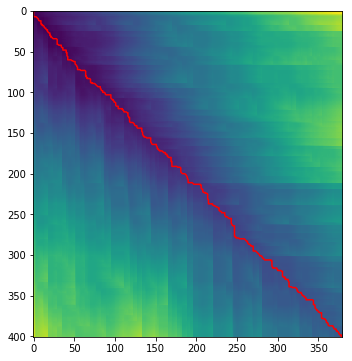

In [5]:
plt.imshow(dtw_acc_cost)
plt.plot(dtw_path[:,1], dtw_path[:,0], 'r')
plt.show()

In [6]:
params = { 'c': 5, 'max_run_count': 3}
otw = OnlineTimeWarping(ref_seq, params)

In [7]:
otw.set_live(live_seq)

  eval(0,0)


cur index 0 0
  Get Inc at (0,0)
    row min [0, 0:1]
    col min [0:1, 0]
    best_point: (0,0)
Both
row[1 : 0,1]
  eval(1,0)
     [0.018468718542676288]
     0.0184687185427
col[0,2 : 1]
  eval(0,1)
     [0.43114599035339962]
     0.431145990353
  eval(1,1)
     [0.44736011736848269, 0.86003738917920602, 0.86358789471644948]
     0.447360117368
run-count 1


cur index 1 1
  Get Inc at (1,1)
    row min [1, 0:2]
    col min [0:2, 1]
    best_point: (1,0)
Both
row[2 : 0,2]
  eval(2,0)
     [0.024185892670546383]
     0.0241858926705
  eval(2,1)
     [0.46223322217408203, 0.88540744687201833, 0.89456337754974757]
     0.462233222174
col[0,3 : 2]
  eval(0,2)
     [0.90822326658440466]
     0.908223266584
  eval(1,2)
     [0.93789739666853578, 1.3987605458844579, 1.4122205489535058]
     0.937897396669
  eval(2,2)
     [0.95308451585980114, 1.4287486903542548, 1.4290627047399209]
     0.95308451586
run-count 1


cur index 2 2
  Get Inc at (2,2)
    row min [2, 0:3]
    col m

     [2.0276267605314655, 2.0788985599562251, 2.0171823660429027]
     2.01718236604
run-count 1


cur index 27 19
  Get Inc at (27,19)
    row min [27, 15:20]
    col min [23:28, 19]
    best_point: (27,18)
Row
row[28 : 15,20]
  eval(28,15)
     [10000000000.950165, 4.6329890543212073, 5.7573342495130122]
     4.63298905432
  eval(28,16)
     [5.5437305681223004, 4.1522692349938426, 5.5043078465746058]
     4.15226923499
  eval(28,17)
     [5.0746507302343851, 4.2354685904682619, 5.0862907116738345]
     4.23546859047
  eval(28,18)
     [4.2649320353704123, 2.0433548057712208, 3.3720139850320212]
     2.04335480577
  eval(28,19)
     [2.0605855773759325, 2.0344131376476144, 2.0483529040784934]
     2.03441313765
run-count 2


cur index 28 19
  Get Inc at (28,19)
    row min [28, 15:20]
    col min [24:29, 19]
    best_point: (27,19)
Column
col[24,29 : 20]
  eval(24,20)
     [4.0896568949234116, 10000000000.7757, 4.8201040370389556]
     4.08965689492
  eval(25,20)
     [4.061873000492

     [10.076525098353549, 11.033120009060733, 11.004817250968028]
     10.0765250984
  eval(56,48)
     [9.7928931875190361, 10.802421066940996, 10.620290076696158]
     9.79289318752
  eval(57,48)
     [10.692068226742316, 10.715486334882071, 10.912183513657659]
     10.6920682267
  eval(58,48)
     [11.218749424716318, 11.618748599991223, 11.622835825877093]
     11.2187494247
run-count 1


cur index 58 48
  Get Inc at (58,48)
    row min [58, 44:49]
    col min [54:59, 48]
    best_point: (58,46)
Row
row[59 : 44,49]
  eval(59,44)
     [10000000000.535576, 9.983147025577459, 10.437624791250931]
     9.98314702558
  eval(59,45)
     [10.519782625203032, 10.062630490132641, 10.520841946119276]
     10.0626304901
  eval(59,46)
     [10.504411743688092, 9.8378065065914129, 10.40955739761797]
     9.83780650659
  eval(59,47)
     [10.698106804803356, 11.152369349679354, 11.116625849459847]
     10.6981068048
  eval(59,48)
     [11.588302917215218, 12.10894553712818, 12.072461276291136]
  

     15.0116769301
run-count 1


cur index 94 79
  Get Inc at (94,79)
    row min [94, 75:80]
    col min [90:95, 79]
    best_point: (93,79)
Column
col[90,95 : 80]
  eval(90,80)
     [15.945248636603175, 10000000000.240644, 10000000000.481287]
     15.9452486366
  eval(91,80)
     [15.059724930332777, 15.951309250046659, 15.716726334527996]
     15.0597249303
  eval(92,80)
     [15.015054445381091, 15.067360256872673, 15.068934969969087]
     15.0150544454
  eval(93,80)
     [15.007970419519202, 15.016749157223126, 15.010808542525265]
     15.0079704195
  eval(94,80)
     [15.024186197495821, 15.020479686937161, 15.031294242513084]
     15.0204796869
run-count 2


cur index 94 80
  Get Inc at (94,80)
    row min [94, 76:81]
    col min [90:95, 80]
    best_point: (93,80)
Column
col[90,95 : 81]
  eval(90,81)
     [16.222479728795317, 10000000000.277231, 10000000000.554462]
     16.2224797288
  eval(91,81)
     [15.063053034191647, 16.225807832654187, 15.951904844320913]
     15.0630530

cur index 122 113
  Get Inc at (122,113)
    row min [122, 109:114]
    col min [118:123, 113]
    best_point: (122,109)
Row
row[123 : 109,114]
  eval(123,109)
     [10000000000.863617, 19.996306806254331, 10000000001.727236]
     19.9963068063
  eval(123,110)
     [20.844246115118235, 19.988035150462256, 20.828567978645797]
     19.9880351505
  eval(123,111)
     [20.019898314757349, 19.973570548479422, 19.203822170188534]
     19.2038221702
  eval(123,112)
     [19.243885736457774, 20.824040407861645, 20.021834516722809]
     19.2438857365
  eval(123,113)
     [19.280271231027537, 21.655108183896957, 20.85674783073193]
     19.280271231
run-count 3


cur index 123 113
  Get Inc at (123,113)
    row min [123, 109:114]
    col min [119:124, 113]
    best_point: (123,111)
exceeded run count
Column
col[119,124 : 114]
  eval(119,114)
     [22.893118653976629, 10000000000.92955, 23.871297185966174]
     22.893118654
  eval(120,114)
     [22.863783359725918, 23.814979756777024, 23.807290629

cur index 157 142
  Get Inc at (157,142)
    row min [157, 138:143]
    col min [153:158, 142]
    best_point: (156,142)
exceeded run count
Row
row[158 : 138,143]
  eval(158,138)
     [10000000000.664116, 26.53364235712878, 26.659569329928864]
     26.5336423571
  eval(158,139)
     [27.153189262066928, 25.745458339076897, 27.108620262298349]
     25.7454583391
  eval(158,140)
     [26.412806169941888, 25.972038358013204, 26.460607095868735]
     25.972038358
  eval(158,141)
     [26.564800165214404, 25.930803761470848, 26.490214141550609]
     25.9308037615
  eval(158,142)
     [26.449917473962469, 25.874483307127313, 26.376269379252889]
     25.8744833071
run-count 1


cur index 158 142
  Get Inc at (158,142)
    row min [158, 138:143]
    col min [154:159, 142]
    best_point: (156,142)
Column
col[154,159 : 143]
  eval(154,143)
     [28.860670143447649, 10000000000.908382, 29.768122083217484]
     28.8606701434
  eval(155,143)
     [27.054093524139788, 29.347237052310373, 28.9254216

     29.022313898
  eval(183,168)
     [29.039446318834358, 29.032536770856844, 29.042604732692993]
     29.0325367709
  eval(183,169)
     [29.041652886128283, 29.011698213093069, 29.033636580516117]
     29.0116982131
  eval(183,170)
     [29.027463708474031, 29.031210040806684, 29.034113088583556]
     29.0274637085
run-count 2


cur index 183 170
  Get Inc at (183,170)
    row min [183, 166:171]
    col min [179:184, 170]
    best_point: (181,170)
Column
col[179,184 : 171]
  eval(179,171)
     [30.831539840894088, 10000000000.3557, 32.696283854040914]
     30.8315398409
  eval(180,171)
     [29.679248537344215, 31.489964775984216, 31.79269020470883]
     29.6792485373
  eval(181,171)
     [29.637401369643612, 30.311192843448591, 30.284712214462836]
     29.6374013696
  eval(182,171)
     [29.645616243849489, 30.267573068067378, 30.265800460386771]
     29.6456162438
  eval(183,171)
     [29.653152532767226, 30.271305068142684, 30.266822194012114]
     29.6531525328
run-count 1


cu

  eval(215,197)
     [43.408449924386744, 43.348845581628176, 43.406359596454315]
     43.3488455816
run-count 2


cur index 215 197
  Get Inc at (215,197)
    row min [215, 193:198]
    col min [211:216, 197]
    best_point: (213,197)
Column
col[211,216 : 198]
  eval(211,198)
     [45.413279182387086, 10000000000.748463, 10000000001.496925]
     45.4132791824
  eval(212,198)
     [43.31529948492414, 45.432378717357487, 44.703015260290876]
     43.3152994849
  eval(213,198)
     [43.290576293792121, 43.31960776924732, 43.304816518600099]
     43.2905762938
  eval(214,198)
     [43.3042093984144, 43.299582962232002, 43.304281346348702]
     43.2995829622
  eval(215,198)
     [43.40232268804133, 43.353060068645156, 43.402156942800829]
     43.3530600686
run-count 3


cur index 215 198
  Get Inc at (215,198)
    row min [215, 194:199]
    col min [211:216, 198]
    best_point: (213,198)
exceeded run count
Row
row[216 : 194,199]
  eval(216,194)
     [10000000000.901901, 46.916957051592469,

     [47.14171026014057, 47.147359512589794, 47.110667244300338]
     47.1106672443
  eval(246,230)
     [47.11509932762236, 47.159546377641014, 47.146741013787697]
     47.1150993276
  eval(246,231)
     [47.124406132370289, 47.168277126446959, 47.17372790381485]
     47.1244061324
  eval(246,232)
     [47.151808526132243, 47.189566637591142, 47.213775109222944]
     47.1518085261
run-count 1


cur index 246 232
  Get Inc at (246,232)
    row min [246, 228:233]
    col min [242:247, 232]
    best_point: (242,232)
Column
col[242,247 : 233]
  eval(242,233)
     [47.164583507498961, 10000000000.072525, 47.313400190566952]
     47.1645835075
  eval(243,233)
     [47.133732180263976, 47.180720469091689, 47.124332416785442]
     47.1243324168
  eval(244,233)
     [47.197779363748054, 47.140740188317643, 47.150410761735642]
     47.1407401883
  eval(245,233)
     [47.196423202633042, 47.174999147121497, 47.249889509823561]
     47.1749991471
  eval(246,233)
     [47.24044577413764, 47.263636

     [10000000000.641783, 54.932066669842605, 10000000001.283567]
     54.9320666698
  eval(277,258)
     [55.572979354219463, 54.972465317987215, 55.572108741542124]
     54.972465318
  eval(277,259)
     [55.512489759003309, 54.73995261057901, 55.411601515642552]
     54.7399526106
  eval(277,260)
     [55.608123025937957, 55.911868986441164, 55.936269000280802]
     55.6081230259
  eval(277,261)
     [56.474695316853293, 56.752248758572264, 56.776843152912882]
     56.4746953169
run-count 2


cur index 277 261
  Get Inc at (277,261)
    row min [277, 257:262]
    col min [273:278, 261]
    best_point: (273,261)
Column
col[273,278 : 262]
  eval(273,262)
     [55.240279457034795, 10000000000.872625, 56.003347258155692]
     55.240279457
  eval(274,262)
     [55.577437932004678, 56.051891390268629, 55.99087824829251]
     55.577437932
  eval(275,262)
     [56.194932308412142, 56.40960356620176, 56.430157267165008]
     56.1949323084
  eval(276,262)
     [56.699968742961303, 57.00922458

     [62.224681161931358, 10000000000.010063, 10000000000.020128]
     62.2246811619
  eval(307,293)
     [62.229419347666855, 62.236697550782296, 62.238649992679164]
     62.2294193477
  eval(308,293)
     [62.251193835202066, 62.24918336657467, 62.256930996631539]
     62.2491833666
  eval(309,293)
     [62.469363562166649, 62.349444967356554, 62.431953017858014]
     62.3494449674
  eval(310,293)
     [62.39794889376693, 62.356418729210873, 62.383049485093402]
     62.3564187292
run-count 2


cur index 310 293
  Get Inc at (310,293)
    row min [310, 289:294]
    col min [306:311, 293]
    best_point: (306,293)
Column
col[306,311 : 294]
  eval(306,294)
     [62.616095339489533, 10000000000.391415, 10000000000.782829]
     62.6160953395
  eval(307,294)
     [62.625946854812895, 63.012622846635573, 63.017736176223437]
     62.6259468548
  eval(308,294)
     [62.627228395590372, 63.003991883828597, 62.985509405698259]
     62.6272283956
  eval(309,294)
     [62.481570681667009, 62.7593

     65.6444150952
run-count 1


cur index 342 320
  Get Inc at (342,320)
    row min [342, 316:321]
    col min [338:343, 320]
    best_point: (340,320)
Column
col[338,343 : 321]
  eval(338,321)
     [64.485998410860475, 10000000000.003674, 64.614631715878375]
     64.4859984109
  eval(339,321)
     [64.47611961348484, 64.503543016504267, 64.517415006235055]
     64.4761196135
  eval(340,321)
     [64.448100761372871, 64.483680097414037, 64.473695975699442]
     64.4481007614
  eval(341,321)
     [65.093518308243461, 64.784292599546816, 65.112923953791565]
     64.7842925995
  eval(342,321)
     [66.554701176052504, 65.694578680439832, 66.577898631855547]
     65.6945786804
run-count 1


cur index 342 321
  Get Inc at (342,321)
    row min [342, 317:322]
    col min [338:343, 321]
    best_point: (340,321)
Column
col[338,343 : 322]
  eval(338,322)
     [64.492198821075291, 10000000000.006201, 10000000000.012402]
     64.4921988211
  eval(339,322)
     [64.498822752125434, 64.514901959

     72.514888129
  eval(372,356)
     [72.576994840359404, 72.585110452477892, 72.556793257901916]
     72.5567932579
  eval(373,356)
     [72.816393110572434, 72.709041572817299, 72.811269146685788]
     72.7090415728
  eval(374,356)
     [73.466048421560174, 73.182102732906529, 73.610267115835512]
     73.1821027329
run-count 2


cur index 374 356
  Get Inc at (374,356)
    row min [374, 352:357]
    col min [370:375, 356]
    best_point: (371,356)
Column
col[370,375 : 357]
  eval(370,357)
     [72.584233130058763, 10000000000.068907, 10000000000.137815]
     72.5842331301
  eval(371,357)
     [72.562997249005576, 72.632342250090829, 72.611543812371025]
     72.562997249
  eval(372,357)
     [72.576193647462162, 72.582397638565823, 72.553688908093989]
     72.5536889081
  eval(373,357)
     [72.786760995551987, 72.631408330828677, 72.712232103371292]
     72.6314083308
  eval(374,357)
     [73.855231573890819, 73.304537171812967, 74.055299254785865]
     73.3045371718
run-count 3




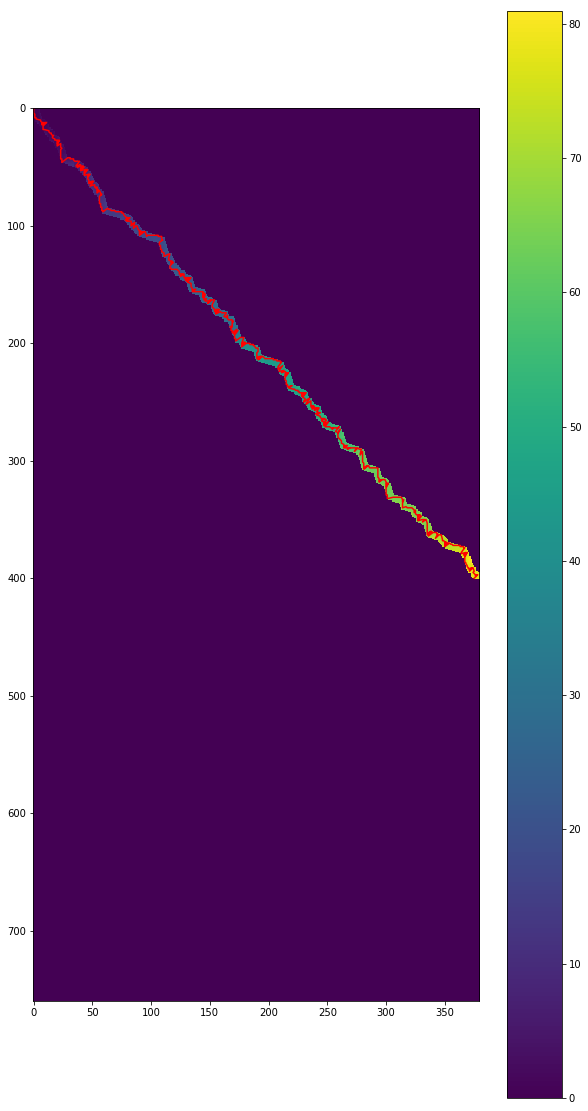

In [8]:
otw_acc_cost = otw.acc_cost.copy()
otw_acc_cost[otw_acc_cost > 10**5] = 0

plt.figure(figsize=(10,20))
plt.imshow(otw_acc_cost)
plt.colorbar()
plt.plot(otw.path[:,1], otw.path[:,0], 'r')
plt.show()

In [9]:
for x in otw.path: print x

[0 0]
[1 0]
[2 0]
[3 0]
[4 0]
[5 1]
[6 1]
[7 1]
[8 1]
[8 2]
[9 2]
[10  6]
[11  6]
[12  7]
[12  8]
[13  7]
[12  9]
[14  7]
[12 10]
[12 11]
[15  8]
[16  8]
[17  8]
[18  8]
[18  9]
[19 13]
[20 13]
[21 14]
[21 15]
[22 15]
[23 16]
[23 17]
[24 16]
[25 16]
[26 18]
[27 18]
[27 19]
[27 20]
[28 20]
[27 21]
[29 20]
[30 20]
[27 22]
[31 20]
[32 20]
[30 23]
[33 23]
[34 24]
[35 23]
[36 23]
[37 23]
[37 23]
[38 23]
[39 23]
[40 23]
[40 23]
[41 23]
[42 23]
[43 23]
[43 24]
[44 24]
[45 24]
[46 24]
[42 29]
[42 30]
[42 31]
[43 31]
[43 32]
[43 33]
[43 34]
[44 34]
[45 35]
[45 36]
[45 37]
[45 37]
[45 38]
[45 39]
[49 36]
[48 40]
[50 37]
[49 41]
[51 40]
[52 40]
[49 42]
[50 43]
[53 40]
[52 44]
[52 45]
[54 43]
[55 43]
[52 46]
[56 43]
[57 43]
[56 47]
[58 46]
[56 48]
[59 46]
[60 46]
[61 47]
[62 47]
[62 47]
[63 47]
[62 50]
[64 47]
[62 51]
[65 49]
[66 48]
[65 52]
[67 52]
[67 53]
[68 53]
[67 54]
[69 54]
[70 54]
[69 55]
[71 54]
[72 54]
[70 56]
[72 57]
[73 57]
[74 57]
[73 58]
[75 56]
[76 56]
[77 56]
[78 56]
[78 56]
[79 56